# Long & Short

### Importando as bibliotecas

In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Selecionando o par de ações e o período para análise

In [2]:
codigo1 = input('Digite o código da ação na ponta long (CÓDIGO.SA): ')
codigo2 = input('Digite o código da ação na ponta short (CÓDIGO.SA): ')
lista = [codigo1, codigo2]
periodo = int(input('Digite o período da média móvel: '))
periodo2 = int(input('Digite o período do IFR: '))
data_inicial = input('Digite a da inicial da análise (aaaa-mm-dd): ')
data_final = input('Digite a da final da análise (aaaa-mm-dd): ')

Digite o código da ação na ponta long (CÓDIGO.SA): PETR4.SA
Digite o código da ação na ponta short (CÓDIGO.SA): PETR3.SA
Digite o período da média móvel: 20
Digite o período do IFR: 14
Digite a da inicial da análise (aaaa-mm-dd): 2022-01-01
Digite a da final da análise (aaaa-mm-dd): 2022-06-18


### Extraindo arquivos para comparação

In [3]:
def extracao(acoes, data1, data2):
    """Esta função recebe uma lista com os códigos das ações, a data inicial e a data final 
    e retorna um dataset com as cotações das ações dia a dia"""
    
    dataset = pd.DataFrame()
    for acao in acoes:
        dataset[acao] = data.DataReader(name = acao, data_source = 'yahoo', 
                                        start = data_inicial, end = data_final)['Adj Close']
    
    return dataset.reset_index()


In [4]:
df_precos = extracao(lista, data_inicial, data_final)
display(df_precos.head())

,Date,PETR4.SA,PETR3.SA
0,2022-01-03,23.861391,26.265030
1,2022-01-04,23.951620,26.598345
2,2022-01-05,23.024725,25.506746
3,2022-01-06,23.008320,25.481747
4,2022-01-07,23.114954,25.690067


### Cálculo da correlação

In [5]:
def correlacao(dataset):
    """Esta função recebe um dataframe com as cotações das ações e retorna uma matriz de correlação"""
    
    arr1 = np.array(dataset[lista[0]])
    arr2 = np.array(dataset[lista[1]])
    corr = np.corrcoef(arr1, arr2)
    
    return corr


In [6]:
correl = correlacao(df_precos)
display(correl)

array([[1.        , 0.98853781],
       [0.98853781, 1.        ]])

### Cálculo do IFR das ações

In [7]:
def calcifr(dataset):
    """Esta função recebe um dataframe com as cotações das ações 
    e retorna um dataframe com o calculo do IFR"""
    
    df = dataset.copy()
    
    for acoes in dataset.columns[1:]:
        df['Dif ' + acoes] = df[acoes] - df[acoes].shift(1)
        
    df['Var. + ' + codigo1] = 0
    df['Var. - ' + codigo1] = 0
    df['Var. + ' + codigo2] = 0
    df['Var. - ' + codigo2] = 0    
    

    for i in range(1, len(df)):  
        if df.loc[i, df.columns[3]] > 0:
            df.loc[i, 'Var. + ' + codigo1] = df.loc[i, df.columns[3]]
        elif df.loc[i, df.columns[3]] < 0:
            df.loc[i, 'Var. - ' + codigo1] = abs(df.loc[i, df.columns[3]])
        else:
            pass
    
    for i in range(1, len(df)):  
        if df.loc[i, df.columns[4]] > 0:
            df.loc[i, 'Var. + ' + codigo2] = df.loc[i, df.columns[4]]
        elif df.loc[i, df.columns[4]] < 0:
            df.loc[i, 'Var. - ' + codigo2] = abs(df.loc[i, df.columns[4]])
        else:
            pass
    
    df['Media Var+' + codigo1] = 0
    df['Media Var-' + codigo1] = 0
    df['Media Var+' + codigo2] = 0
    df['Media Var-' + codigo2] = 0
    
    df.loc[periodo2, 'Media Var+' + codigo1] = df.loc[1: periodo2, 'Var. + ' + codigo1].mean()
    df.loc[periodo2, 'Media Var-' + codigo1] = df.loc[1: periodo2, 'Var. - ' + codigo1].mean()
    df.loc[periodo2, 'Media Var+' + codigo2] = df.loc[1: periodo2, 'Var. - ' + codigo2].mean()
    df.loc[periodo2, 'Media Var-' + codigo2] = df.loc[1: periodo2, 'Var. + ' + codigo2].mean()
    
    for i in range(periodo2 + 1, len(df)):
        df.loc[i, 'Media Var+' + codigo1] = ((df.loc[i - 1, 'Media Var+' + codigo1] * (periodo2 - 1)) 
                                             + df.loc[i, 'Var. + ' + codigo1]) / periodo2
    
    for i in range(periodo2 + 1, len(df)):
        df.loc[i, 'Media Var-' + codigo1] = ((df.loc[i - 1, 'Media Var-' + codigo1] * (periodo2 - 1)) 
                                             + df.loc[i, 'Var. - ' + codigo1]) / periodo2
    
    for i in range(periodo2 + 1, len(df)):
        df.loc[i, 'Media Var+' + codigo2] = ((df.loc[i - 1, 'Media Var+' + codigo2] * (periodo2 - 1)) 
                                             + df.loc[i, 'Var. + ' + codigo2]) / periodo2
    
    for i in range(periodo2 + 1, len(df)):
        df.loc[i, 'Media Var-' + codigo2] = ((df.loc[i - 1, 'Media Var-' + codigo2] * (periodo2 - 1)) 
                                             + df.loc[i, 'Var. - ' + codigo2]) / periodo2
    
    df['RS ' + codigo1] = 0
    df['RS ' + codigo2] = 0
    
    for i in range(periodo2, len(df)):
        df.loc[i, 'RS ' + codigo1] =  df.loc[i, 'Media Var+' + codigo1] / df.loc[i, 'Media Var-' + 
                                                                                 codigo1]
        
    for i in range(periodo2, len(df)):
        df.loc[i, 'RS ' + codigo2] =  df.loc[i, 'Media Var+' + codigo2] / df.loc[i, 'Media Var-' + 
                                                                                 codigo2]
        
    df['RSI ' + codigo1] = 0
    df['RSI ' + codigo2] = 0
    
    for i in range(periodo2, len(df)):
        df.loc[i, 'RSI ' + codigo1] = 100 - (100 / (1 + df.loc[i, 'RS ' + codigo1]))
        
    for i in range(periodo2, len(df)):
        df.loc[i, 'RSI ' + codigo2] = 100 - (100 / (1 + df.loc[i, 'RS ' + codigo2]))
        
    df.drop(labels = df.columns[:-2], axis = 1, inplace = True)
    
    df['RSI 30'] = 30
    df['RSI 70'] = 70
    return df


In [8]:
rsi = calcifr(df_precos)
display(rsi.tail())

,RSI PETR4.SA,RSI PETR3.SA,RSI 30,RSI 70
110,46.750709,48.540732,30,70
111,43.800528,44.866974,30,70
112,46.932412,47.355659,30,70
113,42.877534,44.171777,30,70
114,32.564190,31.686644,30,70


### Cálculo do Ratio, Média e Bandas de Bollinger de n períodos

In [9]:
def calc_ratio(dataset):
    """Esta função recebe um dataset com as cotações 
    e retorna o ratio do par junto com a média móvel e as bandas de bollinger"""
    
    df = dataset.copy()
    df['Ratio'] = dataset[lista[0]] / dataset[lista[1]]
    
    df.drop(labels = [lista[0], lista[1]], axis = 1, inplace = True)
    df.reset_index()
    df['MA'] = 0.0
    df['BB superior'] = 0.0
    df['BB inferior'] = 0.0
    
    for i in range(0, len(df)):
        if i <= periodo - 1:
            df.loc[i, 'MA'] = 0
        else:
            df.loc[i, 'MA'] = df.loc[i - periodo: i, 'Ratio'].mean()
            
    for i in range(0, len(df)):
        if i <= periodo - 1:
            df.loc[i, 'BB superior'] = 0
        else:
            df.loc[i, 'BB superior'] = df['MA'][i] + (2 * df.loc[i - periodo: i, 'Ratio'].std())
    
    for i in range(0, len(df)):
        if i <= periodo - 1:
            df.loc[i, 'BB inferior'] = 0
        else:
            df.loc[i, 'BB inferior'] = df['MA'][i] - (2 * df.loc[i - periodo: i, 'Ratio'].std())
    
    return df

In [10]:
ratio = calc_ratio(df_precos)
display(ratio.tail())

,Date,Ratio,MA,BB superior,BB inferior
110,2022-06-10,0.900942,0.908078,0.923945,0.892210
111,2022-06-13,0.903116,0.906902,0.920059,0.893746
112,2022-06-14,0.905199,0.906608,0.919620,0.893596
113,2022-06-15,0.901147,0.906719,0.919489,0.893949
114,2022-06-17,0.912462,0.907099,0.920063,0.894136


### Visualizando os gráficos

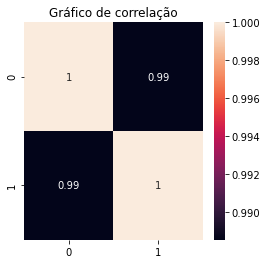

In [11]:
plt.figure(figsize=(4,4))
plt.title('Gráfico de correlação')
sns.heatmap(correl, annot=True);

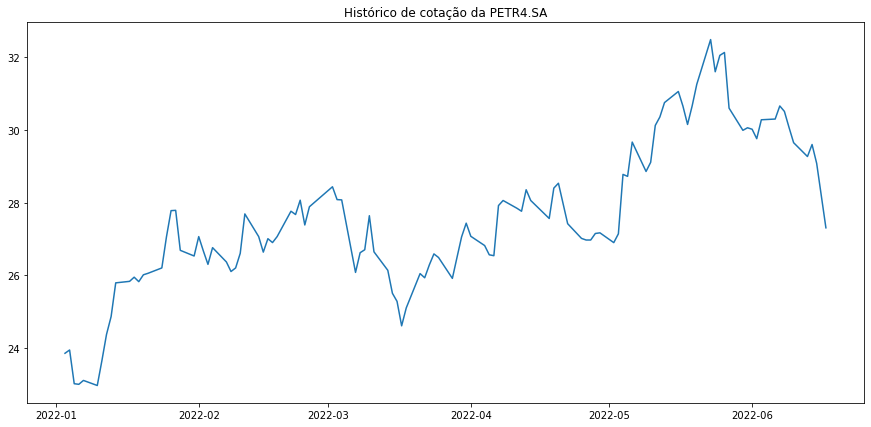

In [12]:
plt.figure(figsize = (15,7))
plt.plot(df_precos[df_precos.columns[0]], df_precos[lista[0]])
plt.title(f'Histórico de cotação da {lista[0]}')

plt.show()


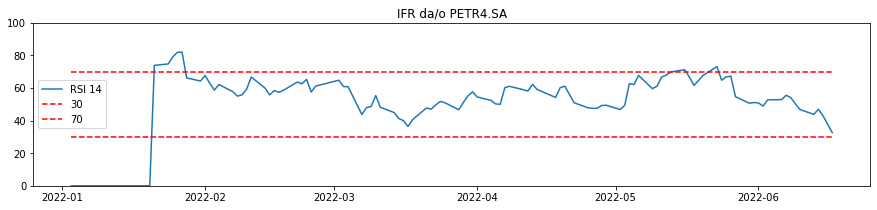

In [13]:
plt.figure(figsize = (15,3))
axes = plt.axes()
axes.set_ylim([0, 100])
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[0]], label = f'RSI {str(periodo2)}')
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[2]], linestyle = '--', color = 'red', label = '30')
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[3]], linestyle = '--', color = 'red', label = '70')
plt.title(f'IFR da/o {lista[0]}')
plt.legend(loc = 'best')

plt.show()

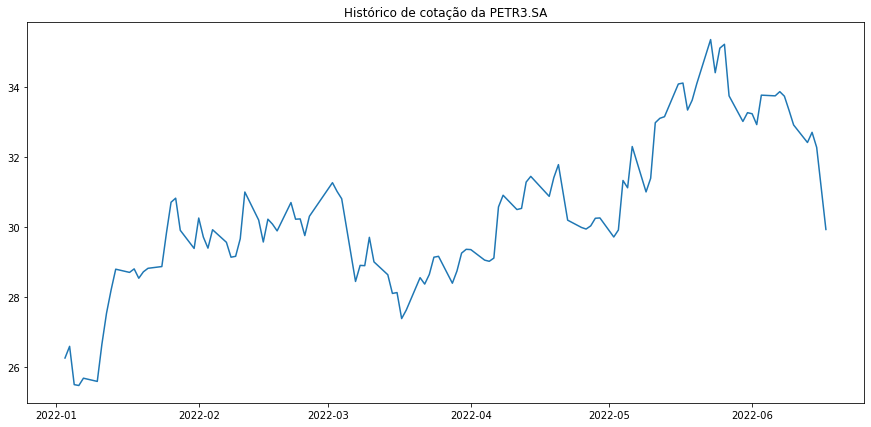

In [14]:
plt.figure(figsize = (15,7))
plt.plot(df_precos[df_precos.columns[0]], df_precos[lista[1]])
plt.title(f'Histórico de cotação da {lista[1]}')

plt.show()

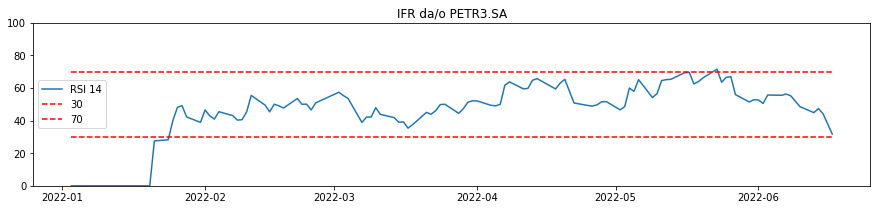

In [15]:
plt.figure(figsize = (15,3))
axes = plt.axes()
axes.set_ylim([0, 100])
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[1]], label = f'RSI {str(periodo2)}')
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[2]], linestyle = '--', color = 'red', label = '30')
plt.plot(df_precos[df_precos.columns[0]], rsi[rsi.columns[3]], linestyle = '--', color = 'red', label = '70')
plt.title(f'IFR da/o {lista[1]}')
plt.legend(loc = 'best')

plt.show()

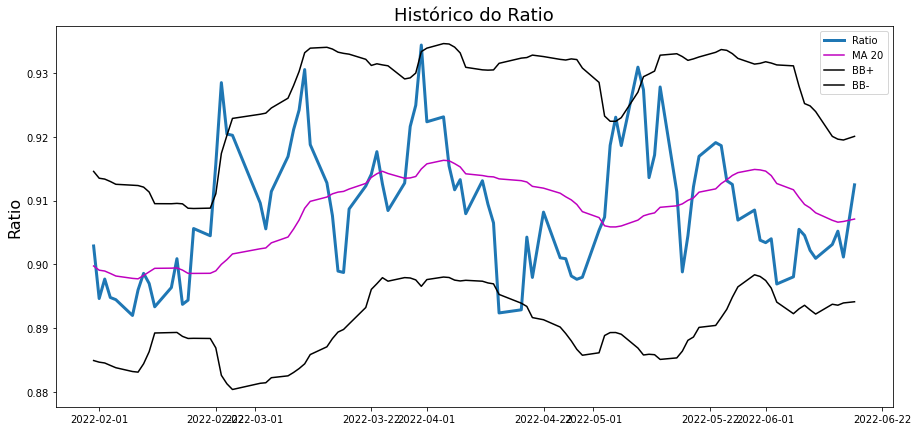

In [16]:
plt.figure(figsize = (15,7))
plt.plot(ratio[ratio.columns[0]][periodo:], ratio[ratio.columns[1]][periodo:], lw = 3, label = 'Ratio')
plt.plot(ratio[ratio.columns[0]][periodo:], ratio[ratio.columns[2]][periodo:], color = 'm', label = 'MA ' + str(periodo))
plt.plot(ratio[ratio.columns[0]][periodo:], ratio[ratio.columns[3]][periodo:], color = 'k', label = 'BB+')
plt.plot(ratio[ratio.columns[0]][periodo:], ratio[ratio.columns[4]][periodo:], color = 'k', label = 'BB-')
plt.title(f'Histórico do Ratio', fontsize = 18)
plt.ylabel('Ratio', fontsize = 16)
plt.legend(loc = 'best')

plt.show()